Data Structure:
  **Rows:**  
  - 0: Column Headers
  - 1 - 531 : Patient ID Number *(int)*

  **Columns:**
  - 0: DID *(int):* Patient ID
  - 1: Mutation *(string)*: CTL (Control), MAPT, C9orf72, GRN
  - 2: AGE_AT_VISIT *(int)*
  - 3: SEX_AT_BIRTH *(string)*: M, F
  - 4: Carrier.Status *(string)*: Carrier, CTL
  - 5: Gene.Dx *(string)*:  mutation status + clinical status
  (“PreSx” suffix = presymptomatic and “Sx” suffix = symptomatic)
  - 6: GLOBALCOG.ZCORE *(float)*: global cognition composite score
  - 7: FTLDCDR_SBL *(int)*: CDR sum of boxes - Clinical Dementia Rating Scale (CDR)
  is a global assessment instrument that yields global and Sum of Boxes (SOB) scores,
  with the global score regularly used in clinical and research settings
  to stage dementia severity. Higher is worse.
  - 8: NFL3_MEAN *(float):* plasma NfL concentrations
  - 9: HasPlasma? *(int)*: 1, 0 (519 Yes)
  - 10 - 7298: Proteins *(float)*:
    Protein variables are annotated as
    Protein Symbol | UniProt ID^Sequence ID| Matrix (CSF or PLASMA).
    The sequence ID is present only if there is more than one target
    for a given protein: e.g.,
    ABL2|P42684^SL010488@seq.3342.76|PLASMA ,
    ABL2|P42684^SL010488@seq.5261.13|PLASMA
  - 7299: HasCSF? *(int)*: 1, 0 (254 Yes)
  - 7300 - 14588: Proteins *(float)*:
  - 14589 - 15212: Clinical Data - maybe not necessary for right now.


/tmp/ipykernel_57052/3705087891.py:6: DtypeWarning: Columns (14923,14929,14930,15002,15004,15005,15006,15007) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/raw/ALLFTD_dataset_for_nina_louisa.csv')


The number of 'CTL' in the 'Carrier.Status' column is: 192
The number of 'Carrier' in the 'Carrier.Status' column is: 338


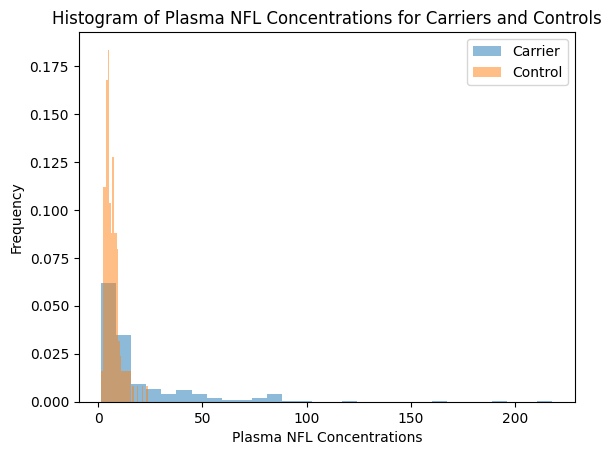

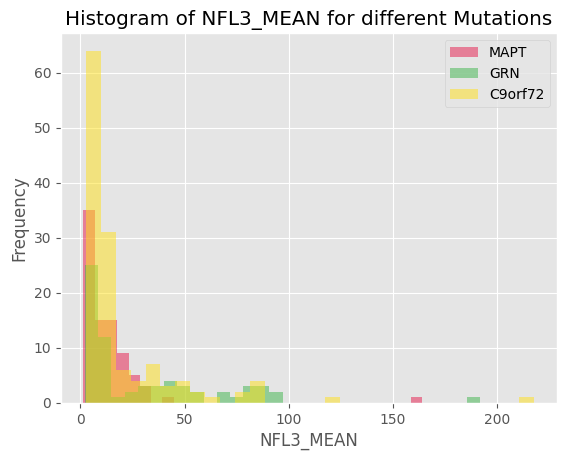

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Load the data
data = pd.read_csv('../data/raw/ALLFTD_dataset_for_nina_louisa.csv')

# Display the first few rows of the data
data.head()

ctl_count = data['Carrier.Status'].value_counts()['CTL']
print(f"The number of 'CTL' in the 'Carrier.Status' column is: {ctl_count}")

carrier_count = data['Carrier.Status'].value_counts()['Carrier']
print(f"The number of 'Carrier' in the 'Carrier.Status' column is: {carrier_count}")


controls = data[data['Carrier.Status'].str.contains('CTL')]
# Plot a histogram of the 'NFL3_MEAN' column

carriers = data[data['Carrier.Status'].str.contains('Carrier')]

plt.hist(carriers['NFL3_MEAN'], bins=30, alpha=0.5, label='Carrier', density=True)
plt.hist(controls['NFL3_MEAN'], bins=30, alpha=0.5, label='Control', density=True)

# Add title and labels
plt.title('Histogram of Plasma NFL Concentrations for Carriers and Controls')
plt.xlabel('Plasma NFL Concentrations')
plt.ylabel('Frequency')
# Add legend
plt.legend()

plt.figure()
plt.style.use('ggplot') 
my_palette = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4']
sns.set_palette(my_palette)

# Filter data based on Mutation
mapt_data = data[data['Mutation'] == 'MAPT']['NFL3_MEAN']
grn_data = data[data['Mutation'] == 'GRN']['NFL3_MEAN']
c903_data = data[data['Mutation'] == 'C9orf72']['NFL3_MEAN']

# Plot histograms
plt.hist(mapt_data, bins=30, alpha=0.5, label='MAPT')
plt.hist(grn_data, bins=30, alpha=0.5, label='GRN')
plt.hist(c903_data, bins=30, alpha=0.5, label='C9orf72')

plt.xlabel('NFL3_MEAN')
plt.ylabel('Frequency')
plt.title('Histogram of NFL3_MEAN for different Mutations')
plt.legend(loc='upper right')

plt.show()





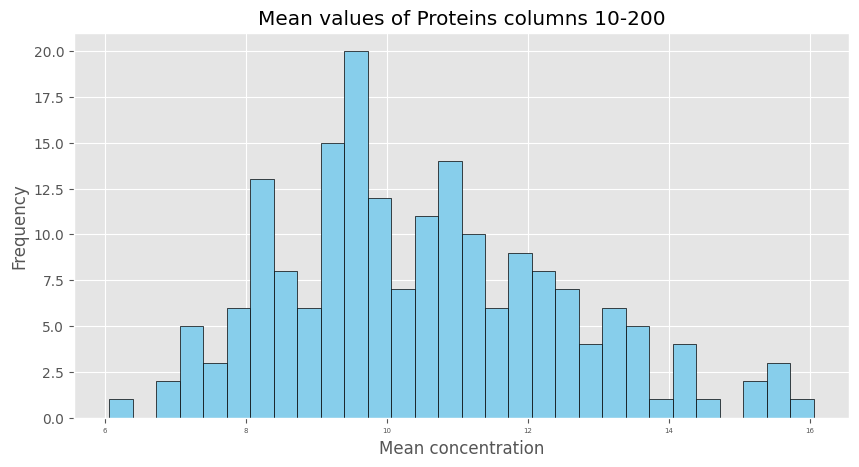

In [4]:
mean_values = data.iloc[:, 10:200].mean()

plt.figure(figsize=(10,5))
mean_values.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Mean values of Proteins columns 10-200')
plt.ylabel('Frequency')
plt.xlabel('Mean concentration')
plt.tick_params(axis='x', labelsize=5)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


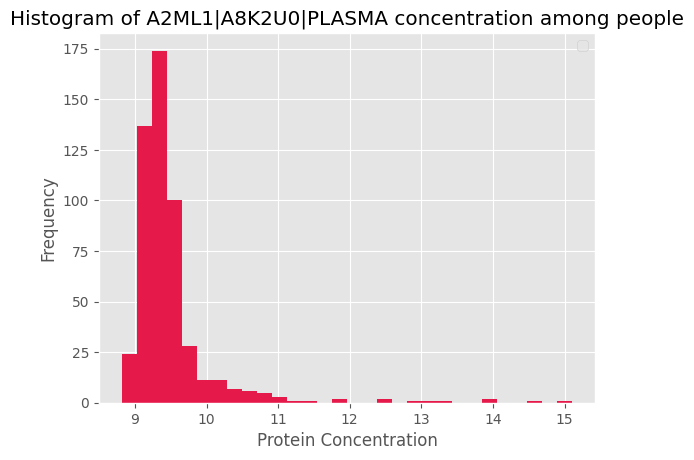

In [5]:
# Plot a histogram of column 30 protein concentration
data['A2ML1|A8K2U0|PLASMA'].hist(bins=30)
plt.xlabel('Protein Concentration')
plt.ylabel('Frequency')
plt.title('Histogram of A2ML1|A8K2U0|PLASMA concentration among people')
plt.legend(loc='upper right')

In [3]:
# Finding 30 most different
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency, ttest_ind
ks_stats = []

mutation_map = {
    "GRN": ["GRN.PreSx", "GRN.Sx"],
    "MAPT": ["MAPT.PreSx", "MAPT.Sx"],
    "C9": ["C9.PreSx", "C9.Sx"],
    "CTL": ["CTL"]
}

if "CTL" in mutation_map:
    mutation_values = mutation_map["CTL"]
    condition1 = data['Gene.Dx'].isin(mutation_values)
    condition2 = ~data['Gene.Dx'].isin(mutation_values)
else:
    raise ValueError("Invalid mutation status specified.")

for i in range(10, 7299):
    protein_column = data.columns[i]

    mutation_data = data[condition1][protein_column]
    other_data = data[condition2][protein_column]

    mutation_data = mutation_data.dropna()
    other_data = other_data.dropna()
    mutation_data = mutation_data[np.isfinite(mutation_data)]
    other_data = other_data[np.isfinite(other_data)]

    ks_statistic, ks_p_value = ks_2samp(mutation_data, other_data)
    ks_stats.append((protein_column, i, ks_statistic, ks_p_value))

ks_stats_df = pd.DataFrame(ks_stats, columns=['Protein', 'Column', 'KS_Statistic', 'P Value'])
top_columns = ks_stats_df.sort_values(by='P Value', ascending=True).head(30)


# Display the top 30 columns with highest KS statistic values
#print(top_columns)
print(top_columns['Protein'].values)

['CXCL12|P48061^SL004712@seq.9278.9|PLASMA'
 'IGFBP2|P18065^SL000466@seq.8469.41|PLASMA' 'GRN|P28799|PLASMA'
 'IGFBP2|P18065^SL000466@seq.8819.3|PLASMA'
 'IGFBP2|P18065^SL000466@seq.2570.72|PLASMA'
 'IGFBP2|P18065^SL000466@seq.22985.160|PLASMA'
 'CXCL12|P48061^SL004712@seq.3516.60|PLASMA'
 'NPTXR|O95502^SL008970@seq.8997.4|PLASMA' 'AIF1L|Q9BQI0|PLASMA'
 'CXCL12|P48061^SL004712@seq.2330.2|PLASMA'
 'LCP1|P13796^SL004609@seq.9749.190|PLASMA' 'C1QTNF1|Q9BXJ1|PLASMA'
 'LCP1|P13796^SL004609@seq.17231.1|PLASMA' 'APOF|Q13790|PLASMA'
 'HPGDS|O60760|PLASMA' 'EFNA3|P52797^SL004139@seq.14153.8|PLASMA'
 'GLTPD2|A6NH11|PLASMA' 'CD68|P34810^SL007199@seq.20528.23|PLASMA'
 'MFAP5|Q13361|PLASMA' 'NPTXR|O95502^SL008970@seq.15511.37|PLASMA'
 'CHCHD10|Q8WYQ3|PLASMA' 'CA3|P07451|PLASMA'
 'STX1A|Q16623^SL004304@seq.3766.51|PLASMA' 'BMP1|P13497|PLASMA'
 'ATP4B|P51164|PLASMA' 'APOL1|O14791^SL005699@seq.11510.31|PLASMA'
 'SCARF2|Q96GP6^SL025991@seq.8956.96|PLASMA'
 'AGR3|Q8TD06^SL012732@seq.5668.49|PLASMA' 'PDL

In [12]:
print(top_30_columns['Column'].values)

[1668 3193 2806 3194 3192 3195 1667 4529  195 1666 3694  739 3695  363
 3031 2037 2699 1040 4068 4530 1234  809 6342  641  505  366 5804  181
 4869 4953]


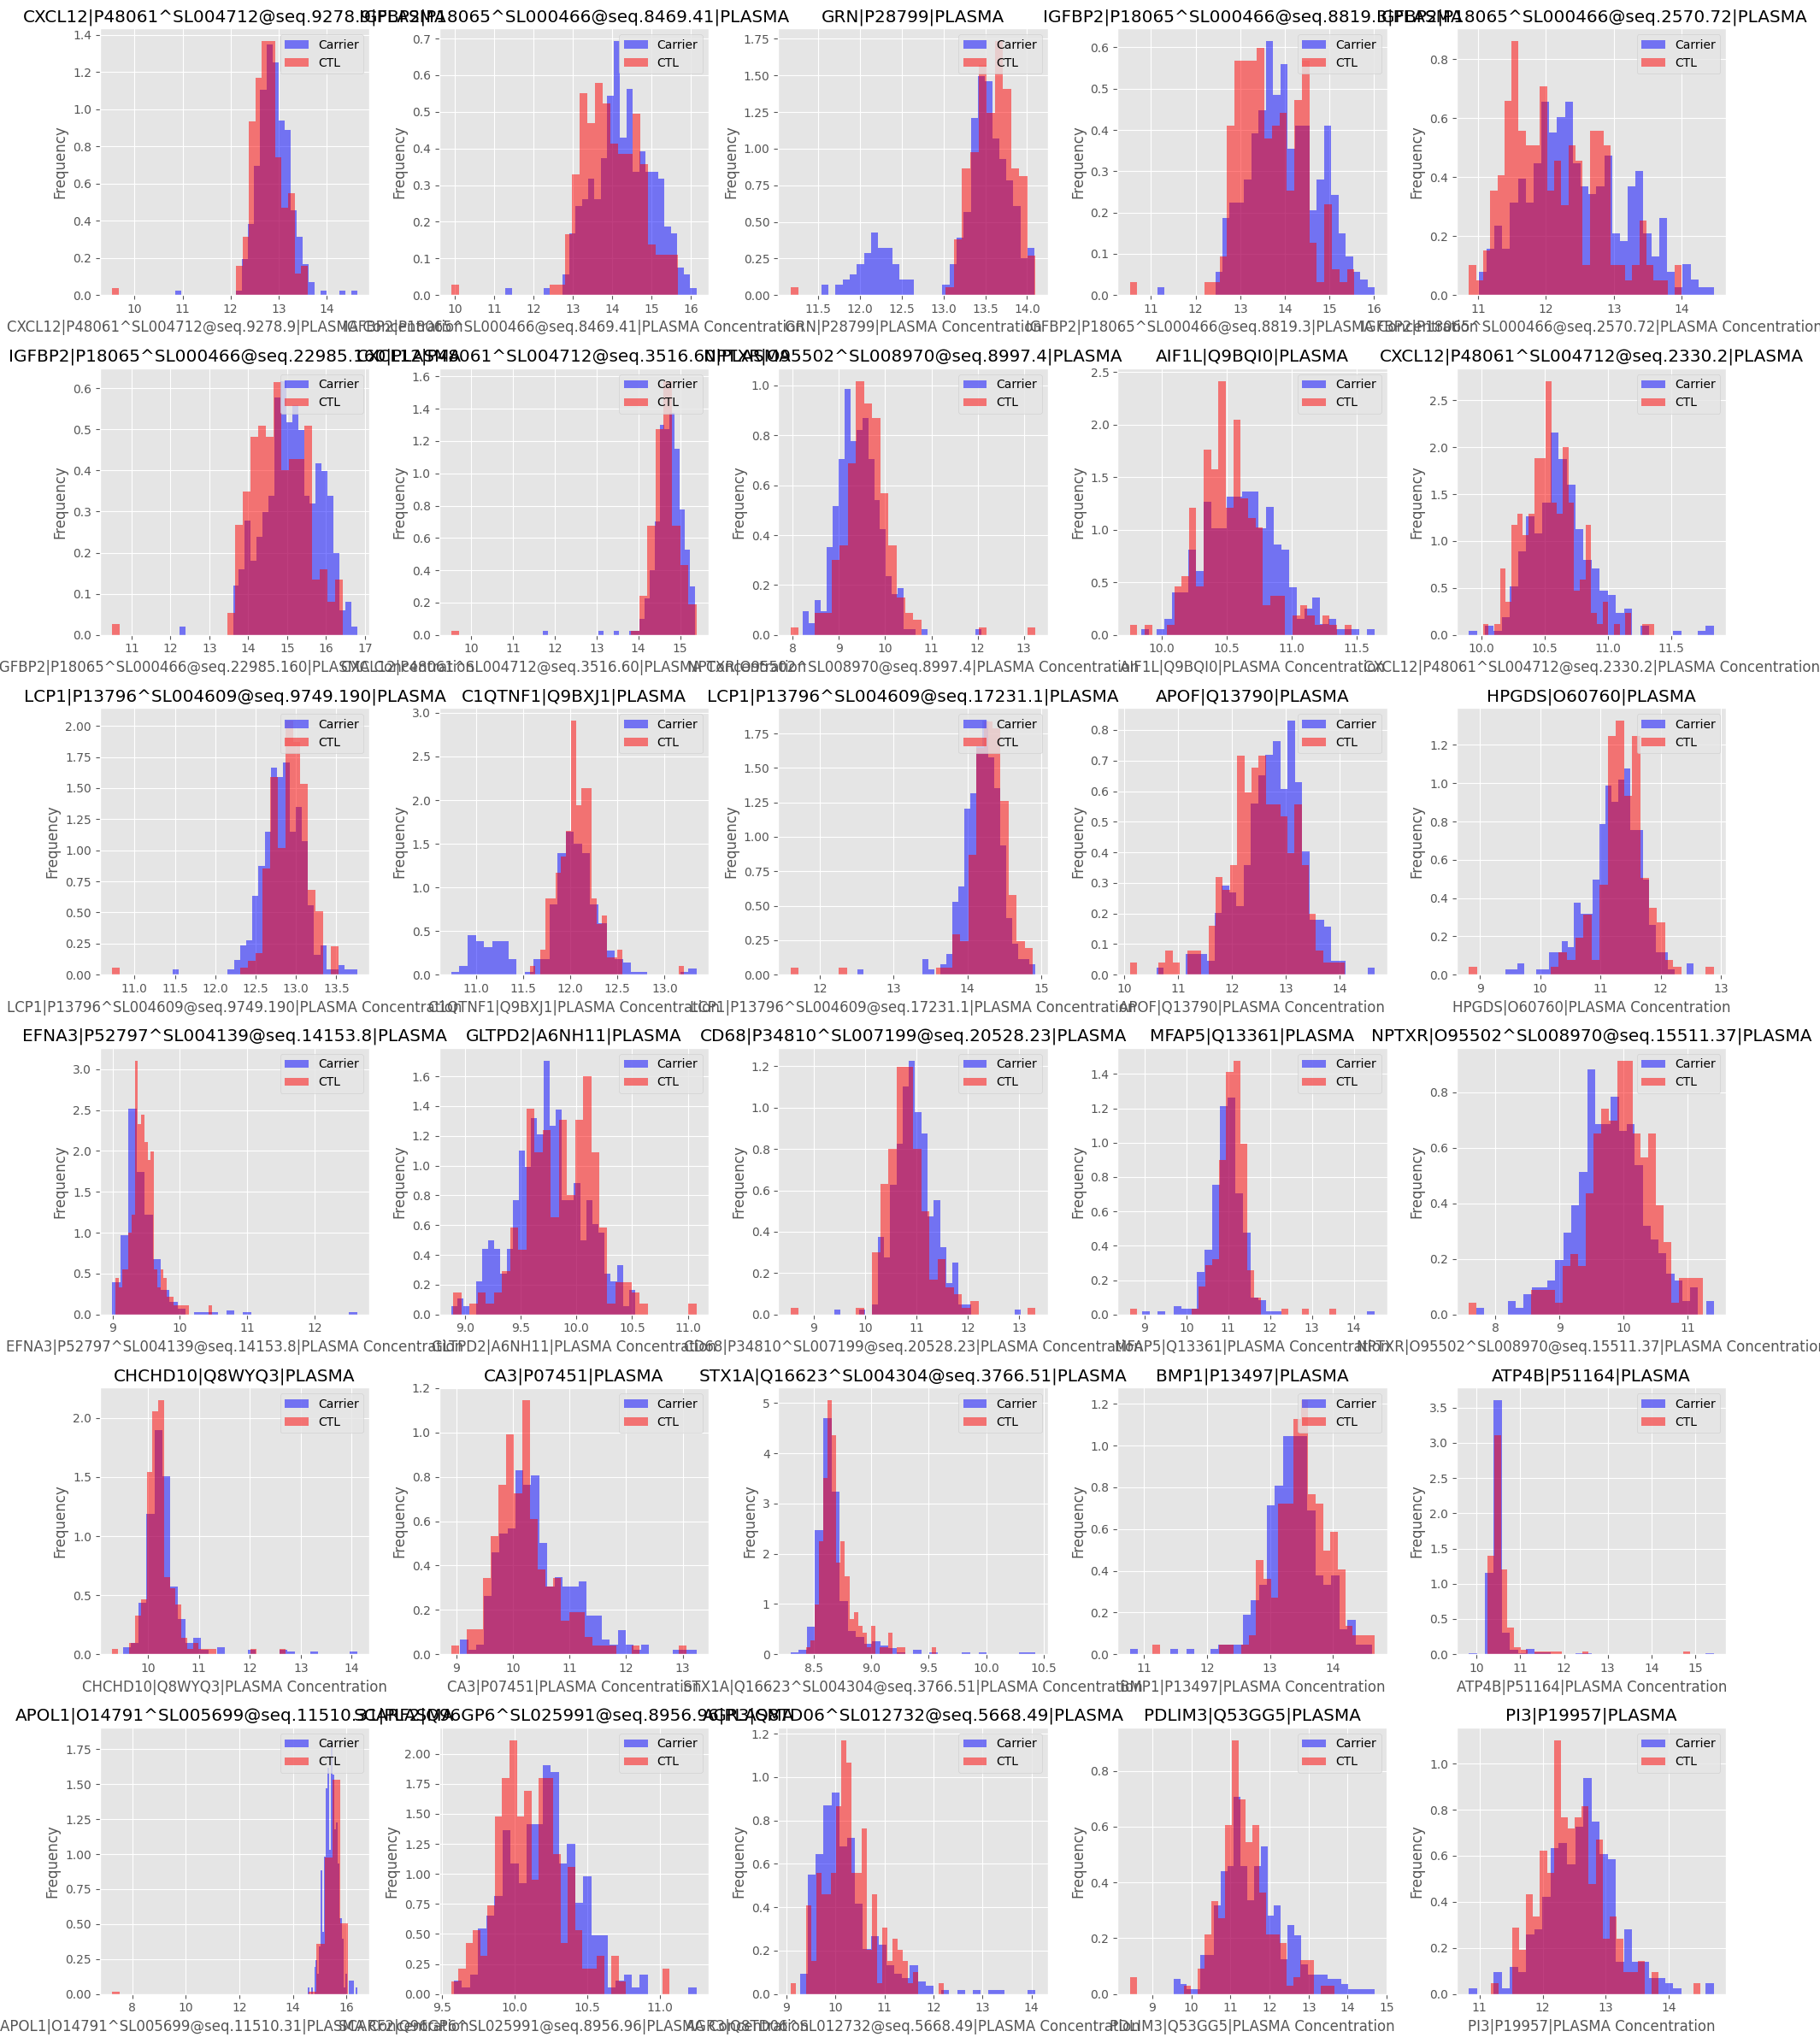

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency, ttest_ind
import numpy as np

# Define the number of plots per row
plots_per_row = 5

# Calculate the number of rows needed
num_rows = (30 + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the first 30 protein columns (assuming they are columns 10 to 39)
for plot_index, i in enumerate(top_30_columns['Column'].values[:30]):
    protein_column = data.columns[i]
    
    # Separate data by "Carrier" and "CTL"
    carrier_data = data[data['Carrier.Status'] == 'Carrier'][protein_column]
    ctl_data = data[data['Carrier.Status'] == 'CTL'][protein_column]

    # Plotting the histograms on the respective subplot
    ax = axes[plot_index]
    ax.hist(carrier_data, bins=30, alpha=0.5, label='Carrier', color='blue', density=True)
    ax.hist(ctl_data, bins=30, alpha=0.5, label='CTL', color='red', density=True)
    
    ax.set_xlabel(f'{protein_column} Concentration')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{protein_column}')
    ax.legend(loc='upper right')

# Hide any unused subplots
for j in range(len(top_30_columns['Column'].values[:30]), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


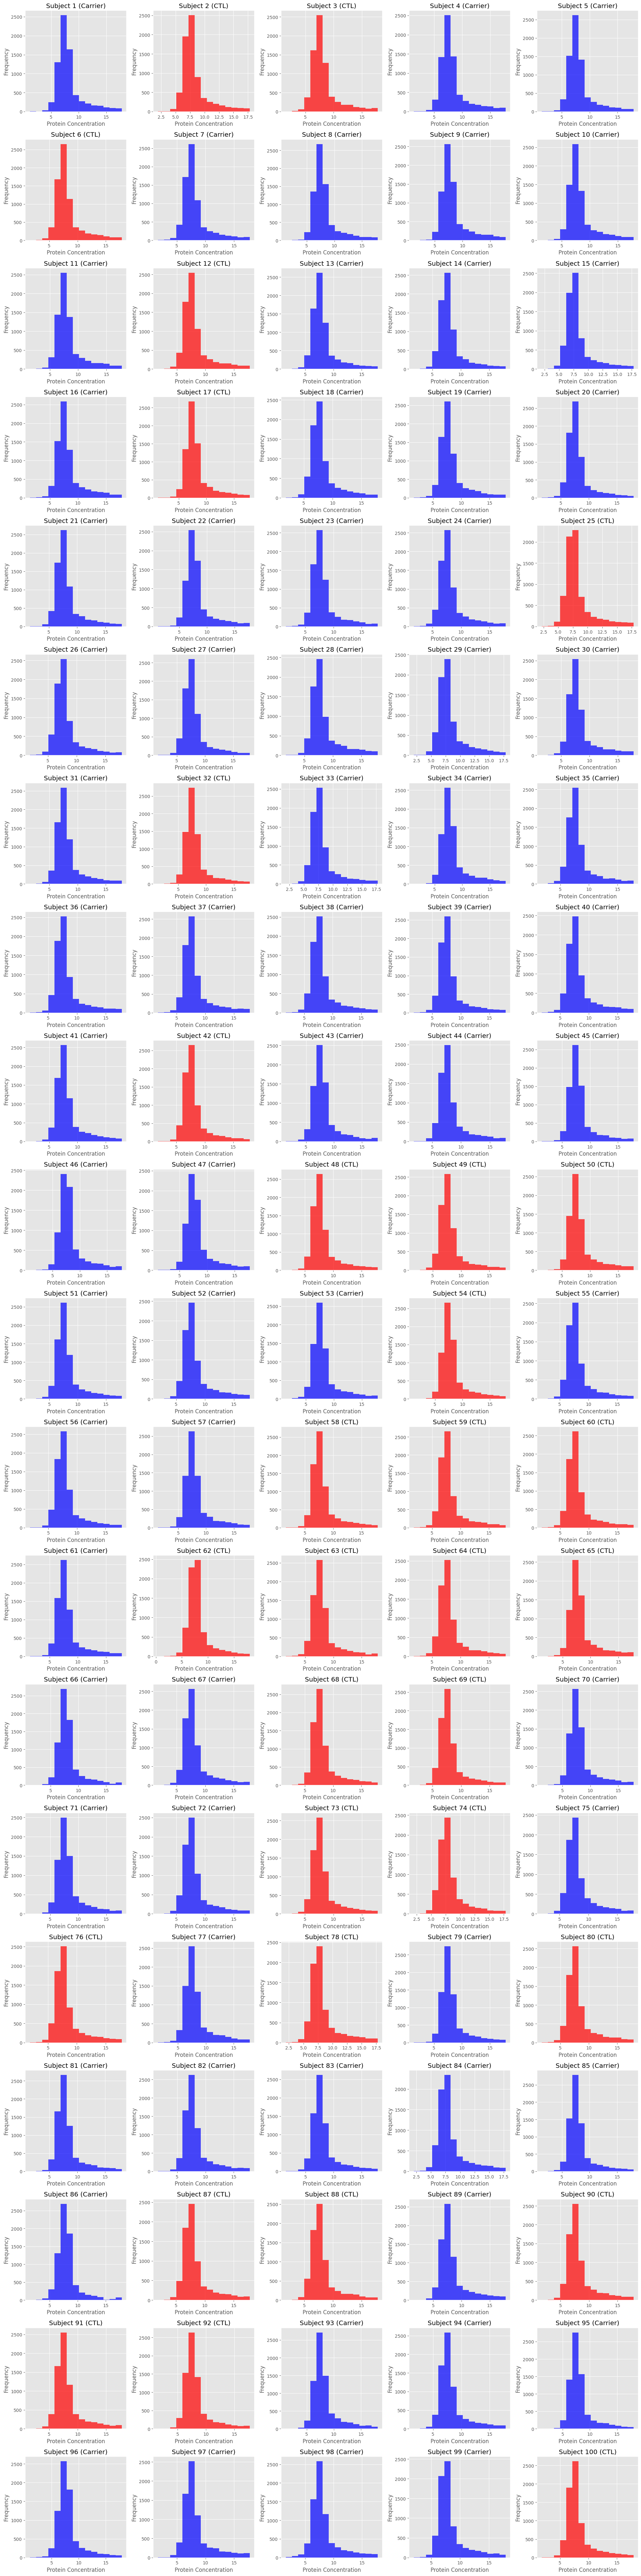

In [11]:
# FOR CSF
# Filter the subjects that have plasma
data = data[data['HasCSF?'] == 1]

# Define the number of subjects to plot
num_subjects = min(100, len(data))  # Plot up to 100 subjects or fewer if less are available

# Define the number of plots per row
plots_per_row = 5

# Calculate the number of rows needed
num_rows = (num_subjects + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the filtered subjects
for i in range(num_subjects):
    subject_data = data.iloc[i, 7300:14588]  # Assuming protein columns start from column 7300
    subject_data = pd.to_numeric(subject_data, errors='coerce').dropna()  # Convert to numeric and drop NaNs
    carrier = data.iloc[i]['Carrier.Status']
    
    # Plotting the histogram on the respective subplot
    ax = axes[i]
    color = 'blue' if carrier == 'Carrier' else 'red'
    
    ax.hist(subject_data, bins=15, alpha=0.7, color=color)  # Reduce bin size to 15
    
    ax.set_xlabel('Protein Concentration')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Subject {i + 1} ({carrier})')

# Hide any unused subplots
for j in range(num_subjects, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

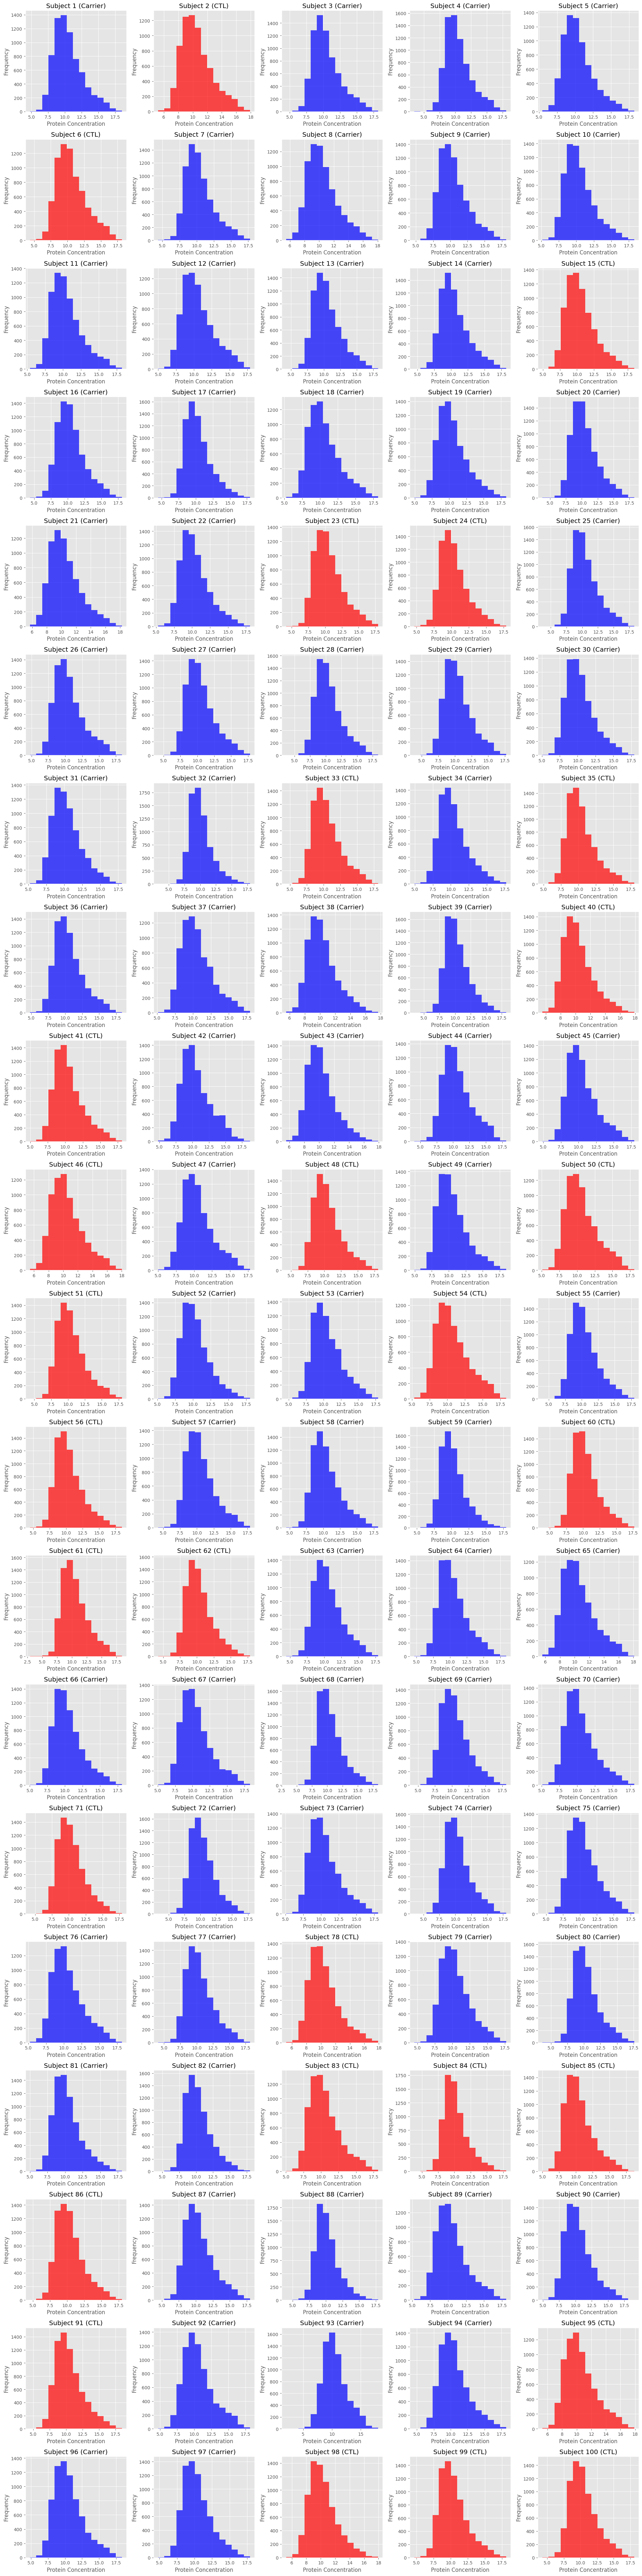

In [14]:
# FOR PLASMA
# Filter the subjects that have plasma
data = data[data['HasPlasma?'] == 1]

# Define the number of subjects to plot
num_subjects = min(100, len(data))  # Plot up to 100 subjects or fewer if less are available

# Define the number of plots per row
plots_per_row = 5

# Calculate the number of rows needed
num_rows = (num_subjects + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the filtered subjects
for i in range(num_subjects):
    subject_data = data.iloc[i, 10:7299]  # Assuming protein columns start from column 10
    subject_data = pd.to_numeric(subject_data, errors='coerce').dropna()  # Convert to numeric and drop NaNs
    carrier = data.iloc[i]['Carrier.Status']
    
    # Plotting the histogram on the respective subplot
    ax = axes[i]
    color = 'blue' if carrier == 'Carrier' else 'red'
    
    ax.hist(subject_data, bins=15, alpha=0.7, color=color)  # Reduce bin size to 15
    
    ax.set_xlabel('Protein Concentration')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Subject {i + 1} ({carrier})')

# Hide any unused subplots
for j in range(num_subjects, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
import os
import numpy as np
import pandas as pd

ROOT_DIR = "/home/lcornelis/code/proteo/proteo/datasets"

ADJACENCY_FOLDER = os.path.join(ROOT_DIR, "data", "ftd", "processed")
ADJACENCY_PATH = os.path.join(ADJACENCY_FOLDER, "adjacency_matrix.csv")

adj_matrix = np.array(pd.read_csv(ADJACENCY_PATH, header=None)).astype(float)
print(adj_matrix.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/home/lcornelis/code/proteo/proteo/datasets/data/ftd/processed/adjacency_matrix.csv'

[[1.00000000e+00 2.94577883e-18 3.11111801e-16 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.01899954e-20 2.60682698e-15
  0.00000000e+00 8.16051511e-16]
 [2.94577883e-18 1.00000000e+00 9.97834977e-15 0.00000000e+00
  1.83788814e-18 2.62354371e-10 0.00000000e+00 2.90848550e-42
  0.00000000e+00 0.00000000e+00]
 [3.11111801e-16 9.97834977e-15 1.00000000e+00 2.88825051e-11
  4.56613120e-05 1.58452736e-12 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.88825051e-11 1.00000000e+00
  3.02523755e-10 4.31894708e-12 8.61297466e-19 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.83788814e-18 4.56613120e-05 3.02523755e-10
  1.00000000e+00 4.52341452e-13 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.62354371e-10 1.58452736e-12 4.31894708e-12
  4.52341452e-13 1.00000000e+00 0.00000000e+00 0.00000000e+00
  5.05221196e-13 0.00000000e+00]
 [8.01899954e-20 0.00000000e+00 0.00000000e+00 8.61297466e

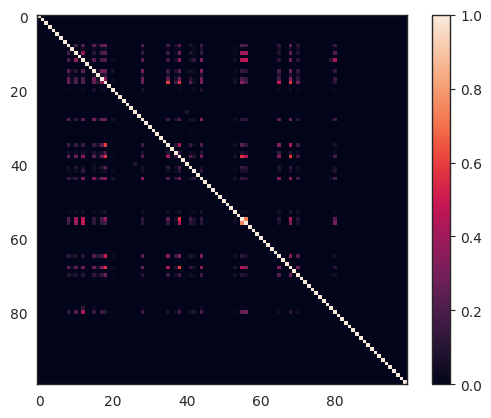

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(adj_matrix[:100, :100])
print(adj_matrix[:10, :10])
plt.colorbar();

GENE EXPRESSION
[[ 0.66964212  0.58538565  0.35485345 ... -0.01034843 -0.38245669
  -0.05489181]
 [-0.68817519  0.18888072 -0.74462287 ...  2.18237716 -0.04916946
  -0.79982196]
 [-0.4877586  -0.36223118 -0.11340701 ...  0.0828062   5.0595944
   0.03592251]
 ...
 [-0.52203773  0.2164463   0.92699325 ... -0.72879074 -0.01126569
  -0.45136942]
 [-0.52203773  0.2164463   0.92699325 ... -0.72879074 -0.01126569
  -0.45136942]
 [-0.76320501 -0.09266775 -1.10607382 ...  0.84001543 -0.60056964
  -0.6222556 ]]
calculating adjacency matrix ...
	Done..

[[1.00000000e+00 1.67622896e-03 3.06770457e-06 0.00000000e+00
  0.00000000e+00]
 [1.67622896e-03 1.00000000e+00 1.92919151e-07 0.00000000e+00
  0.00000000e+00]
 [3.06770457e-06 1.92919151e-07 1.00000000e+00 6.44152068e-06
  3.00126511e-04]
 [0.00000000e+00 0.00000000e+00 6.44152068e-06 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.00126511e-04 0.00000000e+00
  1.00000000e+00]]
[[1.00000000e+00 5.58406785e-04 0.00000000e+00 0.0

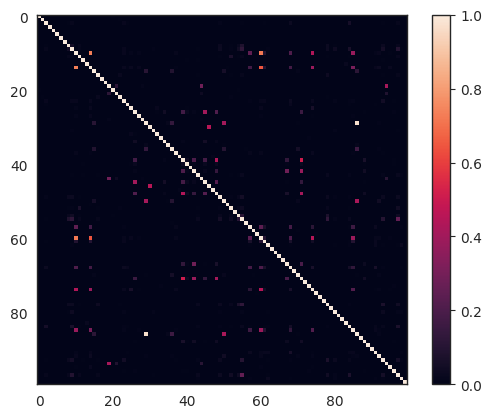

In [ ]:
import PyWGCNA
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT_DIR = "/home/lcornelis/code/proteo/"
EXPRESSION_FOLDER = os.path.join(ROOT_DIR, "MLA-GNN", "example_data", "input_features_labels")
ADJ_FOLDER = os.path.join(ROOT_DIR, "MLA-GNN", "example_data", "input_adjacency_matrix")

# WGCNA parameters
# Probably not necessary since 6 is the default
wgcna_power = 6
wgcna_minModuleSize = 10
wgcna_mergeCutHeight = 0.25


# Read data
geneExp = pd.read_csv(os.path.join(EXPRESSION_FOLDER, "split1_train_320d_features_labels.csv"), header=None) # col = genes, rows = samples 

# Convert the relevant part of the DataFrame to a matrix
geneExp = geneExp.iloc[1:, 82:322].values.astype(float)

# Replace NA values with 0
geneExp = np.nan_to_num(geneExp)
print("GENE EXPRESSION")
print(geneExp[0:10])

# Calculate adjacency matrix.
adjacency = PyWGCNA.WGCNA.adjacency(geneExp, power = wgcna_power, adjacencyType="signed hybrid")
print(adjacency[:5, :5])
plt.imshow(adjacency[:100, :100])
plt.colorbar();

real_adj = np.array(
        pd.read_csv(ADJ_FOLDER +'/'+ 'split1' + '_adjacency_matrix.csv', header=None),
    ).astype(float)
print("============")
print(real_adj[:5, :5])


Shape (7289, 7289)
Threshold: 0.0001
Number of edges tensor(6233217.)
Average degree: 427.57696533203125 for threshold 0.0001


/tmp/ipykernel_3247001/3731686797.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_tensor = torch.tensor(adj_matrix_new)


EDGE INDEX SHAPE torch.Size([2, 6233217])


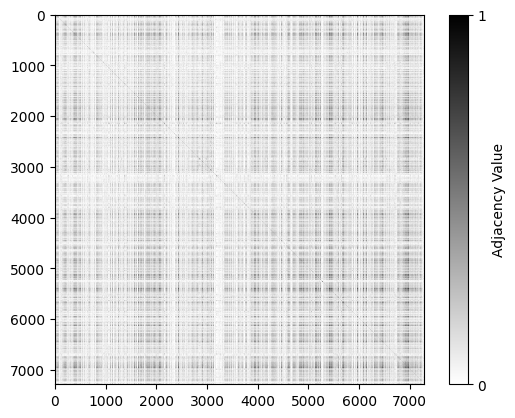

: 

In [ ]:
#ADJANCENCY THRESHOLDING

ROOT_DIR = "/home/lcornelis/code/proteo/proteo/datasets"
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

ADJACENCY_FOLDER = os.path.join(ROOT_DIR, "data", "ftd", "processed")
ADJACENCY_PATH = os.path.join(ADJACENCY_FOLDER, "adjacency_matrix.csv")
adj_matrix = np.array(pd.read_csv(ADJACENCY_PATH, header=None)).astype(float)
print("Shape", adj_matrix.shape)

for threshold in [0.0001]:#, 0.001, 0.01, 0.08, 0.1, 0.5]:
    adj_matrix_new = torch.FloatTensor(
        np.where(adj_matrix > threshold, 1, 0)
    )
    print(f"Threshold: {threshold}")
    Average_degree = (adj_matrix_new.sum()/2) / (adj_matrix_new.shape[0])
    print("Number of edges", adj_matrix_new.sum())
    print(f"Average degree: {Average_degree} for threshold {threshold}")

    adj_tensor = torch.tensor(adj_matrix_new)
    # Find the indices where the matrix has non-zero elements
    pairs_indices = torch.nonzero(adj_tensor, as_tuple=False)
    # Extract the pairs of connected nodes
    edge_index = torch.tensor(pairs_indices.tolist())
    edge_index = torch.transpose(edge_index, 0, 1)  # reshape(edge_index, (2, -1))
    print("EDGE INDEX SHAPE", edge_index.shape)

    plt.figure()
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "black"])
    plt.imshow(adj_matrix_new, cmap=cmap) #0 = white, 1 = black
    plt.colorbar(ticks=[0, 1], label='Adjacency Value')  # Optional



0     5.373790
1     4.968028
2    10.609789
3     7.849056
4     9.952807
5    19.097504
6     3.020361
7     3.955333
8     5.609757
9     2.543992
Name: NFL3_MEAN, dtype: float64
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5    12.0
6     0.0
7     0.0
8     0.0
9     0.5
Name: FTLDCDR_SB, dtype: float64
2.187675633915814


ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

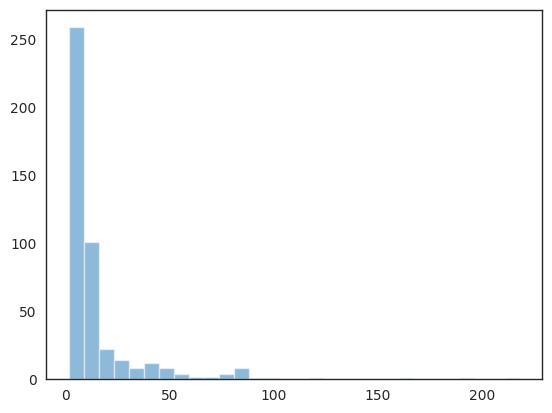

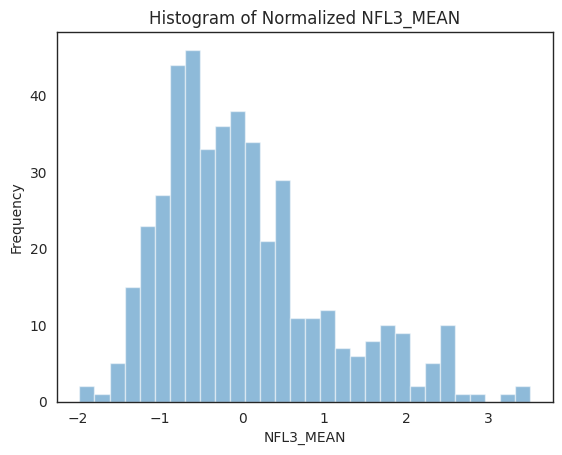

In [16]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv('/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124.csv')

plt.hist(data['NFL3_MEAN'], bins=30, alpha=0.5, label='NFL3_MEAN');

#Normalizing data:

# Sample data with positive values
data_nfl = data['NFL3_MEAN']
data_cdr = data['FTLDCDR_SB']
data_cog_z = data['GLOBALCOG.ZSCORE']

print(data_nfl[:10])
print(data_cdr[:10])

# Log transformation
log_data = np.log(data_nfl)

# Optional: Standardize the log-transformed data
mean = np.mean(log_data)
print(mean)
std = np.std(log_data)
standardized_log_data = (log_data - mean) / std

plt.figure()
plt.hist(standardized_log_data, bins=30, alpha=0.5, label='NFL3_MEAN');
plt.xlabel('NFL3_MEAN')
plt.ylabel('Frequency')
plt.title('Histogram of Normalized NFL3_MEAN')
mean = np.mean(standardized_log_data)
std = np.std(standardized_log_data)
log_data = (standardized_log_data * std) + mean
    
# Reverse the log transformation by applying the exponential function
original_data = np.exp(log_data)
print(original_data == data)

plt.figure()
plt.xlabel('NFL3_MEAN')
plt.ylabel('Frequency')
plt.title('Histogram of Original NFL3_MEAN')
plt.hist(original_data, bins=30, alpha=0.5, label='NFL3_MEAN');



nan


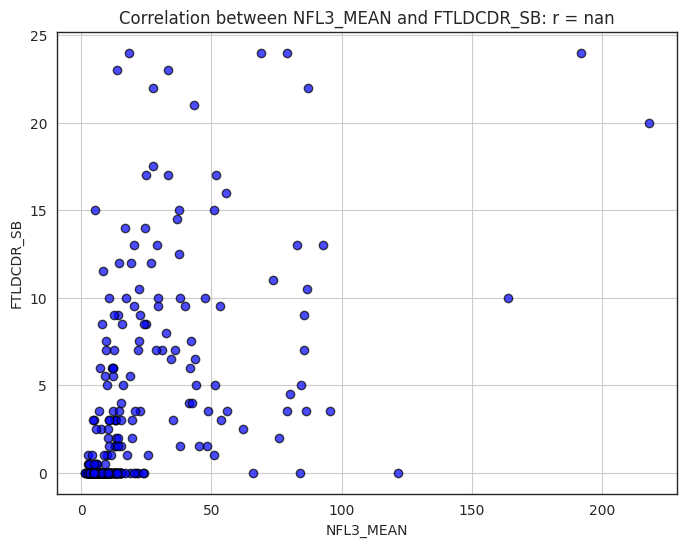

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Extract the two variables of interest
nfl3_mean = data['NFL3_MEAN']
ftldcdr_sb = data['FTLDCDR_SB']

# Calculate the Pearson correlation coefficient
correlation, _ = pearsonr(data_nfl, data_cdr)
print(correlation)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(nfl3_mean, data_cdr, alpha=0.7, color='blue', edgecolor='k')
plt.xlabel('NFL3_MEAN')
plt.ylabel('FTLDCDR_SB')
plt.title(f'Correlation between NFL3_MEAN and FTLDCDR_SB: r = {correlation:.2f}')
plt.grid(True)

# Save the plot to a file
plt.savefig("correlation_plot.png", dpi=300)
plt.show()

/tmp/ipykernel_3760829/817910228.py:3: DtypeWarning: Columns (14932,14938,14939,15011,15013,15014,15015,15016) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124.csv')


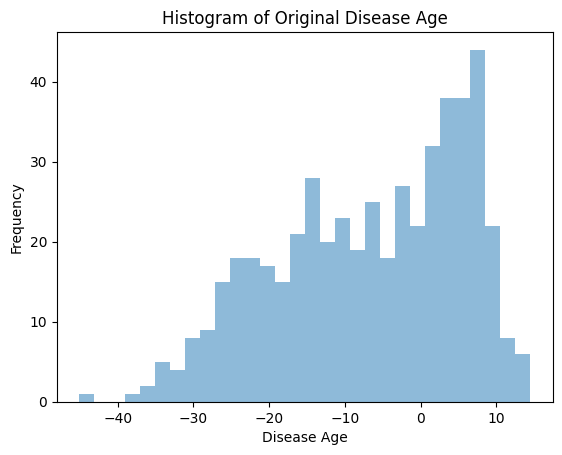

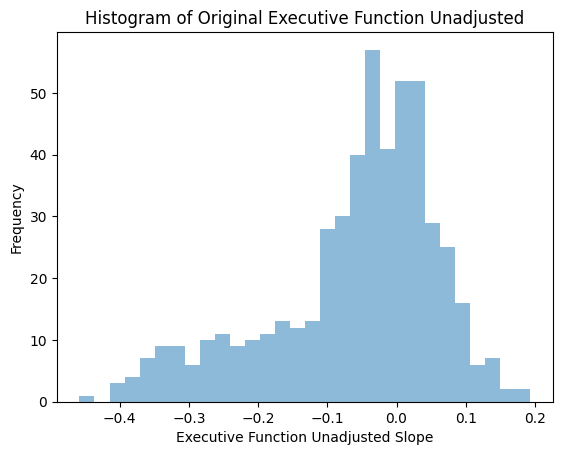

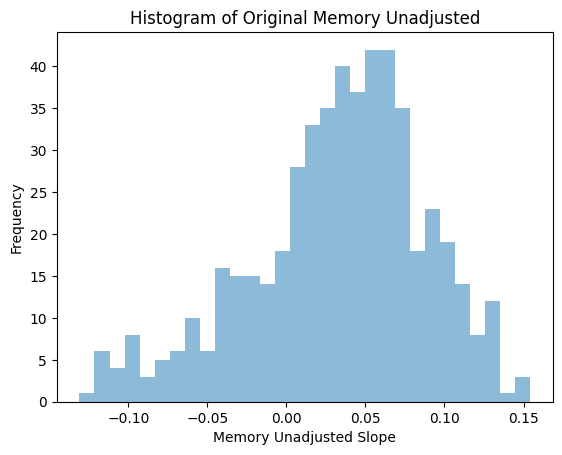

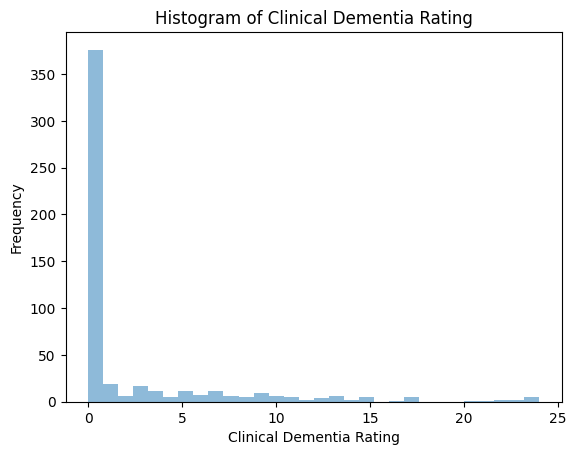

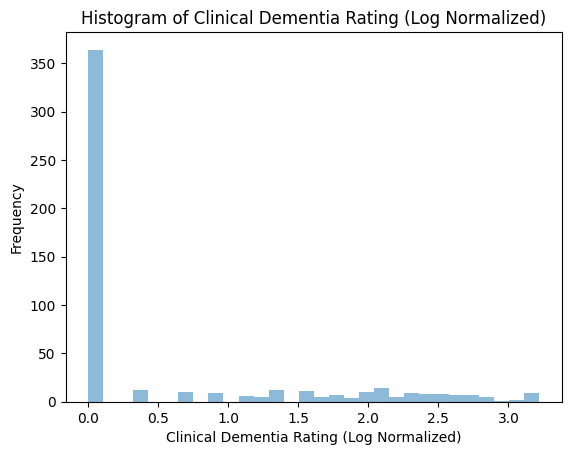

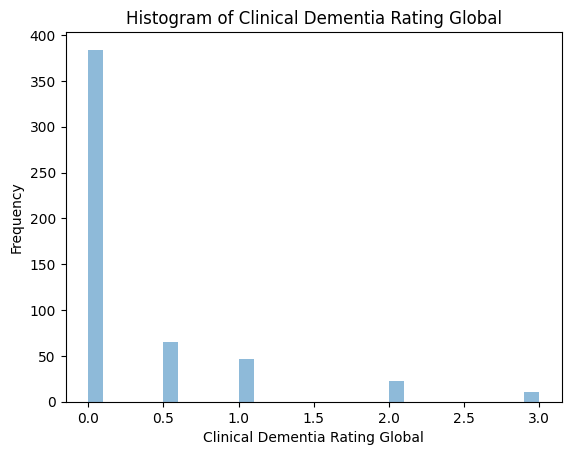

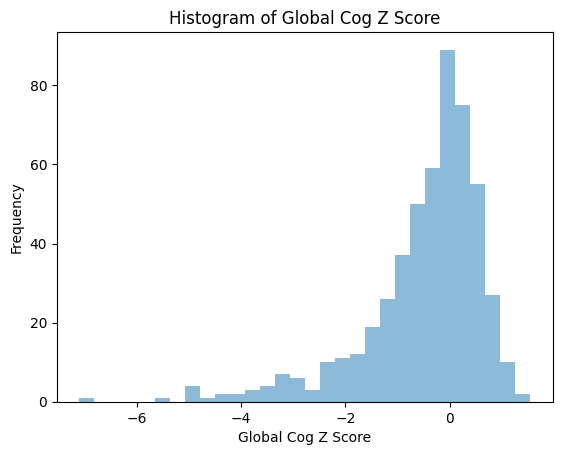

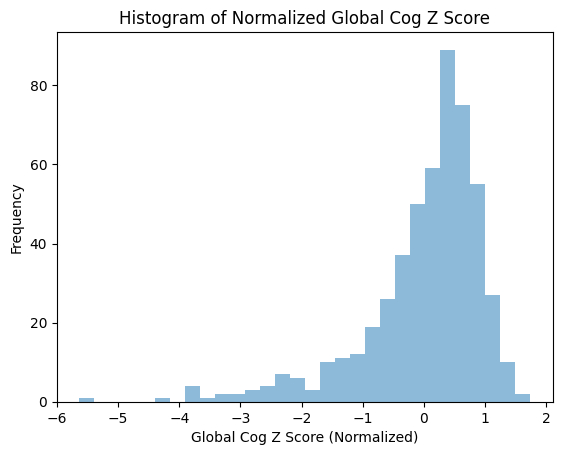

Frequency of 0: 378
Frequency of 0.5: 60
Frequency of 1: 44
Frequency of 2: 20
Frequency of 3: 3


In [13]:
import pandas as pd
from scipy.stats import zscore
data = pd.read_csv('/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124.csv')


plt.hist(data['disease.age'], bins=30, alpha=0.5, label='Disease Age');
plt.xlabel('Disease Age')
plt.ylabel('Frequency')
plt.title('Histogram of Original Disease Age')
plt.figure()

plt.hist(data['ef.unadj.slope'], bins=30, alpha=0.5, label='Disease Age');
plt.xlabel('Executive Function Unadjusted Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Original Executive Function Unadjusted')
plt.figure()

plt.hist(data['mem.unadj.slope'], bins=30, alpha=0.5, label='Disease Age');
plt.xlabel('Memory Unadjusted Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Original Memory Unadjusted')
plt.figure()

plt.hist(data['FTLDCDR_SB'], bins=30, alpha=0.5, label='');
plt.xlabel('Clinical Dementia Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Clinical Dementia Rating')
plt.figure()

data = data.dropna(subset=['FTLDCDR_SB'])
data['FTLDCDR_SB_Log'] = np.log1p(data['FTLDCDR_SB'])

# Step 2: Plot the histogram of the normalized 'CDRGLOB'
plt.hist(data['FTLDCDR_SB_Log'], bins=30, alpha=0.5)
plt.xlabel('Clinical Dementia Rating (Log Normalized)')
plt.ylabel('Frequency')
plt.title('Histogram of Clinical Dementia Rating (Log Normalized)')
plt.show()

plt.hist(data['CDRGLOB'], bins=30, alpha=0.5, label='');
plt.xlabel('Clinical Dementia Rating Global')
plt.ylabel('Frequency')
plt.title('Histogram of Clinical Dementia Rating Global')
plt.figure()


plt.hist(data['GLOBALCOG.ZSCORE'], bins=30, alpha=0.5, label='');
plt.xlabel('Global Cog Z Score')
plt.ylabel('Frequency')
plt.title('Histogram of Global Cog Z Score')
plt.figure()

data = data.dropna(subset=['GLOBALCOG.ZSCORE'])
data['GLOBALCOG.ZSCORE_Z'] = zscore(data['GLOBALCOG.ZSCORE'])

# Plot the histogram of the normalized 'GLOBALCOG.ZSCORE'
plt.hist(data['GLOBALCOG.ZSCORE_Z'], bins=30, alpha=0.5)
plt.xlabel('Global Cog Z Score (Normalized)')
plt.ylabel('Frequency')
plt.title('Histogram of Normalized Global Cog Z Score')
plt.show()



has_measurement = data['HasPlasma?'].astype(int) == 1
cdrglob_values = data.loc[has_measurement, 'CDRGLOB'].astype(float)
specific_values = [0, 0.5, 1, 2, 3]
for value in specific_values:
    count = (cdrglob_values == value).sum()
    print(f'Frequency of {value}: {count}')






In [4]:
import numpy as np

def reverse_log_transform(standardized_log_data, mean, std):
    # De-standardize the data
    log_data = standardized_log_data * std + mean
    original_data = np.exp(log_data)
    return original_data

converted = reverse_log_transform(np.array([0.040640295, 0.110063404, 0.17069, 0.273345172, 0.315212935, 0.335949302, 
 0.387901604, 0.428061336, 0.479374737, 0.488184899]),2.178815827183045, 0.7776541040264751)
print(converted)

sqrt_converted = np.sqrt(converted)
print(sqrt_converted)

print(reverse_log_transform(np.sqrt(np.array([0.040640295, 0.110063404, 0.17069, 0.273345172, 0.315212935, 0.335949302, 
 0.387901604, 0.428061336, 0.479374737, 0.488184899])),2.178815827183045, 0.7776541040264751))

[ 9.11954506  9.62541586 10.09008851 10.92860673 11.29028317 11.47382301
 11.9468674  12.32585985 12.8276572  12.91584455]
[3.01985845 3.10248543 3.17648997 3.30584433 3.36010166 3.38730321
 3.45642408 3.5108204  3.58157189 3.59386207]
[10.3355202  11.43648675 12.18372287 13.26849241 13.67296608 13.86756919
 14.3414277  14.69646347 15.13847276 15.21321618]


Processed file names: ['ftd_y_val_cog_z_score_adj_thresh_0.167_num_nodes_7258_mutation_MAPT,C9orf72,GRN,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_train_nolog.pt', 'ftd_y_val_cog_z_score_adj_thresh_0.167_num_nodes_7258_mutation_MAPT,C9orf72,GRN,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_test_nolog.pt']
Loading data from: /scratch/lcornelis/data/data_louisa/processed/ftd_y_val_cog_z_score_adj_thresh_0.167_num_nodes_7258_mutation_MAPT,C9orf72,GRN,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_train_nolog.pt


Loading data from: /scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv
Number of patients with measurements: 254
Number of patients with mutation status in ['MAPT', 'C9orf72', 'GRN', 'CTL']: 530
Number of patients with sex in ['M', 'F']: 530
Total number of patients with all conditions 254
mean log train -0.41059763104455455
std log train 0.9939248987458366
Dimensions of filtered sex col (252,)
Features shape before master nodes: (252, 7258)
Training features and labels: torch.Size([201, 7258, 1]) torch.Size([201])
Testing features and labels: torch.Size([51, 7258, 1]) torch.Size([51])
--> Total features and labels: (252, 7258) (252,)
Training sex, mutation and age labels shape: torch.Size([201]) torch.Size([201]) torch.Size([201])
Testing sex, mutation and age labels shape: torch.Size([51]) torch.Size([51]) torch.Size([51])
Loading adjacency matrix from: /scratch/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7258_mutation_['MAPT', 

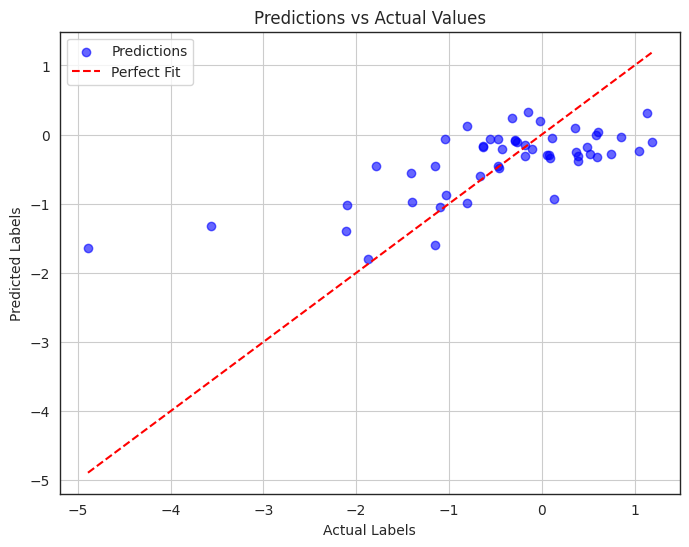

In [17]:
#-----------------RUNNING LINEAR REGRESSION----------------------
from datasets.ftd import HAS_MODALITY_COL, Y_VAL_COL_MAP, MODALITY_COL_END, mutation_col, sex_col, Y_VALS_TO_NORMALIZE, log_transform, BINARY_Y_VALS_MAP, MULTICLASS_Y_VALS_MAP, FTDDataset
from sklearn import linear_model
from sklearn.linear_model import LassoCV
import os
import pandas as pd
import numpy as np
from config_utils import CONFIG_FILE, Config, read_config_from_file
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from proteo.datasets.ftd import FTDDataset, reverse_log_transform
from sklearn.preprocessing import StandardScaler
import torch

cog_z_all_mean = -0.41059763104455455
cog_z_all_std = 0.9939248987458366

cdr_all_mean = 1.812807881773399
cdr_all_std = 3.5666674566521928

# Read configuration
config = read_config_from_file(CONFIG_FILE)
root = config.data_dir

# Load the dataset
train_dataset = FTDDataset(root, "train", config)
(train_features, train_labels, test_features, test_labels, 
 train_sex, test_sex, train_mutation, test_mutation, train_age, test_age, adj_matrices) = train_dataset.load_csv_data(config)

# Print the shapes of features and labels
print("Train Features shape", train_features.shape)
print("Labels shape", train_labels.shape)
print("Test features shape", test_features.shape)
print("Test labels shape", test_labels.shape)

# Squeeze the last dimension of train/test features if needed
train_features = train_features.squeeze(-1).detach().cpu().numpy()
test_features = test_features.squeeze(-1).detach().cpu().numpy()

# Convert PyTorch tensors to NumPy arrays
train_sex = train_sex.detach().cpu().numpy()
train_mutation = train_mutation.detach().cpu().numpy()
train_age = train_age.detach().cpu().numpy()

test_sex = test_sex.detach().cpu().numpy()
test_mutation = test_mutation.detach().cpu().numpy()
test_age = test_age.detach().cpu().numpy()

# Concatenate sex, age, and mutation features with the main train/test features
train_additional_features = np.column_stack([train_sex, train_mutation, train_age])
test_additional_features = np.column_stack([test_sex, test_mutation, test_age])

# Combine the original features with the additional labels (sex, age, mutation)
train_features_with_labels = np.concatenate([train_features, train_additional_features], axis=1)
test_features_with_labels = np.concatenate([test_features, test_additional_features], axis=1)

# Data normalization using StandardScaler
scaler = StandardScaler()
train_features_with_labels = scaler.fit_transform(train_features_with_labels)
test_features_with_labels = scaler.transform(test_features_with_labels)

# Use LassoCV to find the best alpha
lasso_cv = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso_cv.fit(train_features_with_labels, train_labels)

# Best alpha value
print(f"Optimal alpha: {lasso_cv.alpha_}")

# Predict using the model with the best alpha
predictions = lasso_cv.predict(test_features_with_labels)

# Print predictions and true labels
#print("Predictions:", predictions)
#print("Labels:", test_labels)
test_targets = reverse_log_transform(test_labels, cog_z_all_mean, cog_z_all_std)
test_preds = reverse_log_transform(predictions, cog_z_all_mean, cog_z_all_std)
#test_targets = test_targets.numpy()
#test_preds = test_preds.numpy()

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_labels, predictions)
print("Test Mean Squared Error:", mse)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

orig_mse_test = mean_squared_error(test_targets, test_preds)
print("Original Units MSE Test:", orig_mse_test)
print("Original Units RMSE Test:", np.sqrt(orig_mse_test))

# Compute Coefficient of Determination (R^2 Score)
r2 = r2_score(test_labels, predictions)
print("Coefficient of Determination (R^2):", r2)

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, color='blue', alpha=0.6, label='Predictions')
plt.plot([min(test_targets), max(test_targets)], [min(test_targets), max(test_targets)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()


shape of train features torch.Size([179, 7261])
Epoch [10/100], Training Loss: 0.9770, Validation Loss: 0.5443
Epoch [20/100], Training Loss: 0.8594, Validation Loss: 0.4739


Epoch [30/100], Training Loss: 0.6503, Validation Loss: 0.4298
Epoch [40/100], Training Loss: 0.4126, Validation Loss: 0.5011
Early stopping at epoch 41. Validation loss did not improve for 10 epochs.
Test Mean Squared Error: 0.5239989
Test R^2 Score: 0.08498930931091309
Original Units squared error: 204.23201
Original units RMSE 14.290977


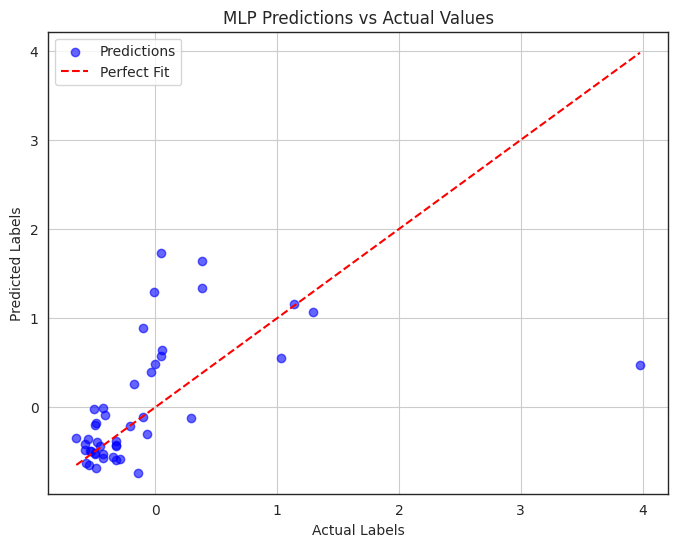

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=7261):
        super(MLP, self).__init__()
        
        # First fully connected layer with larger input size
        self.fc1 = nn.Linear(input_size, 1024)  # Increased to 1024 neurons
        
        # Additional fully connected layers
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        
        # Final output layer (for regression)
        self.fc6 = nn.Linear(64, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)  # Increased dropout to 30%

    def forward(self, x):
        # Apply ReLU activations and dropout after each layer
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        
        # Final layer, no activation (for regression)
        x = self.fc6(x)
        return x

# Hyperparameters
learning_rate = 0.0001
epochs = 100
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
patience_counter = 0


# Convert your data to PyTorch tensors
train_features_with_labels = torch.tensor(train_features_with_labels, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)  # Convert labels to a 2D tensor
test_features_with_labels = torch.tensor(test_features_with_labels, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1)
print("shape of train features", train_features_with_labels.shape)

# Define model, loss function and optimizer
input_size = train_features_with_labels.shape[1]  # Number of input features
model = MLP(input_size)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()  # Zero gradients from previous step
    
    # Forward pass
    predictions = model(train_features_with_labels)
    loss = criterion(predictions, train_labels_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Validation loss calculation
    model.eval()
    with torch.no_grad():
        val_predictions = model(test_features_with_labels)
        val_loss = criterion(val_predictions, test_labels_tensor).item()
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Validation loss did not improve for {patience} epochs.")
            break
    
    # Print the loss at each epoch
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(test_features_with_labels).numpy()
    test_labels_numpy = test_labels_tensor.numpy()

# Calculate the performance metrics
mse = mean_squared_error(test_labels_numpy, test_predictions)

r2 = r2_score(test_labels_numpy, test_predictions)
print("Test Mean Squared Error:", mse)
print("Test R^2 Score:", r2)

train_targets = reverse_log_transform(torch.from_numpy(test_labels_numpy), all_nodes_csf_mean, all_nodes_csf_std)
train_preds = reverse_log_transform(torch.from_numpy(test_predictions), all_nodes_csf_mean, all_nodes_csf_std)

# Convert back to NumPy for calculating metrics
train_targets_numpy = train_targets.numpy()
train_preds_numpy = train_preds.numpy()

orig_mse = mean_squared_error(train_preds, train_targets)
print("Original Units squared error:", orig_mse)
print("Original units RMSE", np.sqrt(orig_mse))

# Plot the predictions vs actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(test_labels_numpy, test_predictions, color='blue', alpha=0.6, label='Predictions')
plt.plot([min(test_labels_numpy), max(test_labels_numpy)], [min(test_labels_numpy), max(test_labels_numpy)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('MLP Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_1289069/1357472196.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/lcornelis/anaconda3/envs/proteo/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


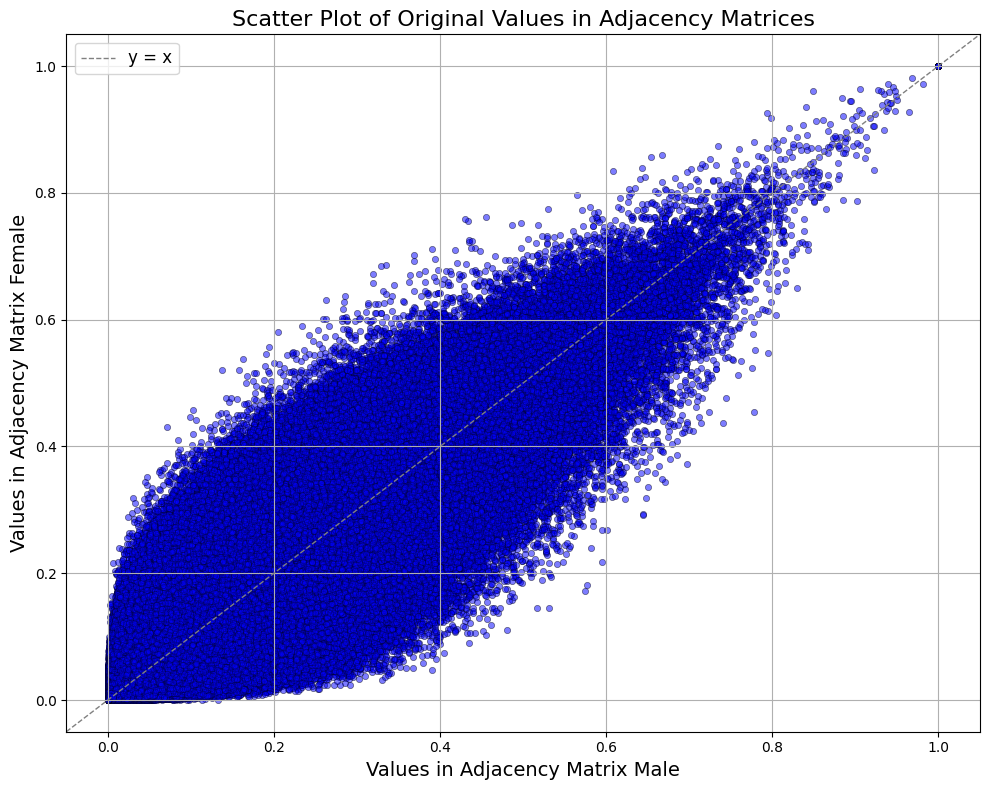

Processing threshold: 0.1
Adjacency matrix: torch.Size([7258, 7258])


/tmp/ipykernel_1289069/1357472196.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_tensor = torch.tensor(adj_matrix)


Adjacency matrix: torch.Size([7258, 7258])
Processing threshold: 0.2
Adjacency matrix: torch.Size([7258, 7258])
Adjacency matrix: torch.Size([7258, 7258])
Processing threshold: 0.3
Adjacency matrix: torch.Size([7258, 7258])
Adjacency matrix: torch.Size([7258, 7258])
Processing threshold: 0.4
Adjacency matrix: torch.Size([7258, 7258])
Adjacency matrix: torch.Size([7258, 7258])
Processing threshold: 0.5
Adjacency matrix: torch.Size([7258, 7258])
Adjacency matrix: torch.Size([7258, 7258])
Processing threshold: 0.6
Adjacency matrix: torch.Size([7258, 7258])
Adjacency matrix: torch.Size([7258, 7258])
Processing threshold: 0.7
Adjacency matrix: torch.Size([7258, 7258])
Adjacency matrix: torch.Size([7258, 7258])
Processing threshold: 0.8
Adjacency matrix: torch.Size([7258, 7258])
Adjacency matrix: torch.Size([7258, 7258])
Processing threshold: 0.9
Adjacency matrix: torch.Size([7258, 7258])
Adjacency matrix: torch.Size([7258, 7258])


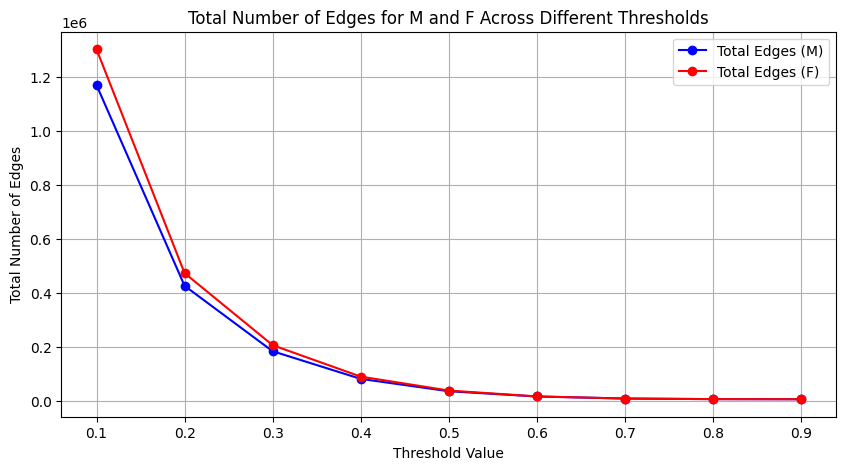

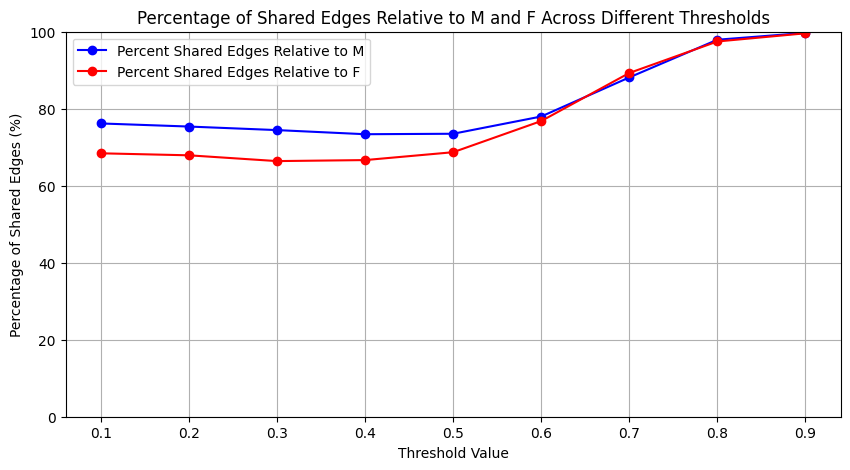

In [9]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


#to load: /scratch/lcornelis/data/data_louisa/processed/adjacency_0.13_num_nodes_7289_mutation_['C9orf72', 'MAPT', 'GRN', 'CTL']_csf_sex_['F']_masternodes_['sex', 'mutation', 'age'].csv
# Selected power to have scale free network is 7.
# to load : /scratch/lcornelis/data/data_louisa/processed/adjacency_0.13_num_nodes_7289_mutation_['C9orf72', 'MAPT', 'GRN', 'CTL']_csf_sex_['M']_masternodes_['sex', 'mutation', 'age'].csv
# Selected power to have scale free network is 6.

adj_threshold_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def load_adjacency_matrix_once(adj_path):
    adj_matrix = np.array(pd.read_csv(adj_path, header=None)).astype(float)
    return adj_matrix

def threshold_to_edge_set(adj_matrix, threshold):
    # Threshold adjacency matrix
    adj_matrix = torch.FloatTensor(np.where(adj_matrix > threshold, 1, 0))
    print("Adjacency matrix:", adj_matrix.shape)
    adj_tensor = torch.tensor(adj_matrix)
    pairs_indices = torch.nonzero(adj_tensor, as_tuple=False)
    edge_set = set(map(tuple, pairs_indices.tolist()))
    return edge_set,  adj_matrix.sum().item()

def compare_adj_matrices_for_thresholds(adj_matrix1, adj_matrix2, threshold_values):
    num_edges_M_list = []
    num_edges_F_list = []
    percent_shared_edges_M_list = []
    percent_shared_edges_F_list = []

    # Create a scatter plot to compare the original values of adj_matrix1 and adj_matrix2
    plt.figure(figsize=(10, 8))
    plt.scatter(adj_matrix1.flatten(), adj_matrix2.flatten(), s=20, alpha=0.3, color='blue', edgecolor='black', linewidth=0.5)
    plt.xlabel('Values in Adjacency Matrix Male', fontsize=14)
    plt.ylabel('Values in Adjacency Matrix Female', fontsize=14)
    plt.title('Scatter Plot of Original Values in Adjacency Matrices', fontsize=16)
    plt.axline((0, 0), slope=1, color='gray', linestyle='--', linewidth=1, label='y = x')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    for threshold in threshold_values:
        print(f"Processing threshold: {threshold}")
        # Apply threshold and get edge sets for M and F
        edge_set1, num_edges1 = threshold_to_edge_set(adj_matrix1, threshold)
        edge_set2, num_edges2 = threshold_to_edge_set(adj_matrix2, threshold)

        # Calculate the number of common edges
        common_edges = edge_set1.intersection(edge_set2)
        num_common_edges = len(common_edges)

        # Calculate the percentage of shared edges relative to the total edges in M and F
        percent_shared_edges_M = (num_common_edges / num_edges1) * 100 if num_edges1 > 0 else 0
        percent_shared_edges_F = (num_common_edges / num_edges2) * 100 if num_edges2 > 0 else 0

        # Append results to corresponding lists
        num_edges_M_list.append(num_edges1)
        num_edges_F_list.append(num_edges2)
        percent_shared_edges_M_list.append(percent_shared_edges_M)
        percent_shared_edges_F_list.append(percent_shared_edges_F)

    return num_edges_M_list, num_edges_F_list, percent_shared_edges_M_list, percent_shared_edges_F_list

#adj_pathM = "/data/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7258_mutation_['GRN', 'MAPT', 'C9orf72', 'CTL']_csf_sex_['M', 'F']_masternodes_False_sex_specific_True_M.csv"
#adj_pathF = "/data/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7258_mutation_['GRN', 'MAPT', 'C9orf72', 'CTL']_csf_sex_['M', 'F']_masternodes_False_sex_specific_True_F.csv"
adj_pathF = "/data/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7258_mutation_['MAPT', 'C9orf72', 'GRN', 'CTL']_csf_sex_['F']_masternodes_False_sex_specific_False.csv"
adj_pathM = "/data/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7258_mutation_['MAPT', 'C9orf72', 'GRN', 'CTL']_csf_sex_['M']_masternodes_False_sex_specific_False.csv"
#adj_pathM = "/data/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7258_mutation_['MAPT', 'C9orf72', 'GRN', 'CTL']_csf_sex_['M', 'F']_masternodes_False_sex_specific_True_M.csv"
#adj_pathF2 = "/data/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7258_mutation_['MAPT', 'C9orf72', 'GRN', 'CTL']_csf_sex_['M', 'F']_masternodes_False_sex_specific_True_F.csv"


# Load the adjacency matrices once
adj_matrix_M = load_adjacency_matrix_once(adj_pathM)
adj_matrix_F = load_adjacency_matrix_once(adj_pathF)

# Compare adjacency matrices for all thresholds
num_edges_M_list, num_edges_F_list, percent_shared_edges_M_list, percent_shared_edges_F_list = compare_adj_matrices_for_thresholds(
    adj_matrix_M, adj_matrix_F, adj_threshold_values
)
# Create the plots
# Plot 1: Total number of edges for M and F across different thresholds
plt.figure(figsize=(10, 5))
plt.plot(adj_threshold_values, num_edges_M_list, marker='o', linestyle='-', color='b', label='Total Edges (M)')
plt.plot(adj_threshold_values, num_edges_F_list, marker='o', linestyle='-', color='r', label='Total Edges (F)')
plt.xlabel('Threshold Value')
plt.ylabel('Total Number of Edges')
plt.title('Total Number of Edges for M and F Across Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Percentage of shared edges relative to the total edges in M and F
plt.figure(figsize=(10, 5))
plt.plot(adj_threshold_values, percent_shared_edges_M_list, marker='o', linestyle='-', color='b', label='Percent Shared Edges Relative to M')
plt.plot(adj_threshold_values, percent_shared_edges_F_list, marker='o', linestyle='-', color='r', label='Percent Shared Edges Relative to F')
plt.xlabel('Threshold Value')
plt.ylabel('Percentage of Shared Edges (%)')
plt.title('Percentage of Shared Edges Relative to M and F Across Different Thresholds')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()




/tmp/ipykernel_611735/1095268251.py:8: DtypeWarning: Columns (14932,14938,14939,15011,15013,15014,15015,15016) have mixed types. Specify dtype option on import or set low_memory=False.
  expression_values = pd.read_csv("/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv", index_col=0)


Index(['SHOX|O15266|CSF', 'DDI2|Q5TDH0|CSF', 'TIAM1|Q13009|CSF',
       'GPX1|P07203|CSF', 'RAB3D|O95716^SL008723@seq.19808.26|CSF',
       'RRM1|P23921|CSF', 'SHKBP1|Q8TBC3|CSF', 'RAB4B|P61018|CSF',
       'DEFB121|Q5J5C9|CSF', 'DHRS11|Q6UWP2|CSF',
       ...
       'TULP1|O00294|CSF', 'SETD2|Q9BYW2|CSF', 'ZCCHC17|Q9NP64|CSF',
       'CFLAR|O15519|CSF', 'SNRPD3|P62318|CSF',
       'GLP1R|P43220^SL025875@seq.20581.42|CSF', 'BRD4|O60885|CSF',
       'JAG1|P78504^SL025897@seq.7754.11|CSF', 'REG4|Q9BYZ8|CSF',
       'WFIKKN1|Q96NZ8|CSF'],
      dtype='object', length=7258)
Are patient IDs aligned? True


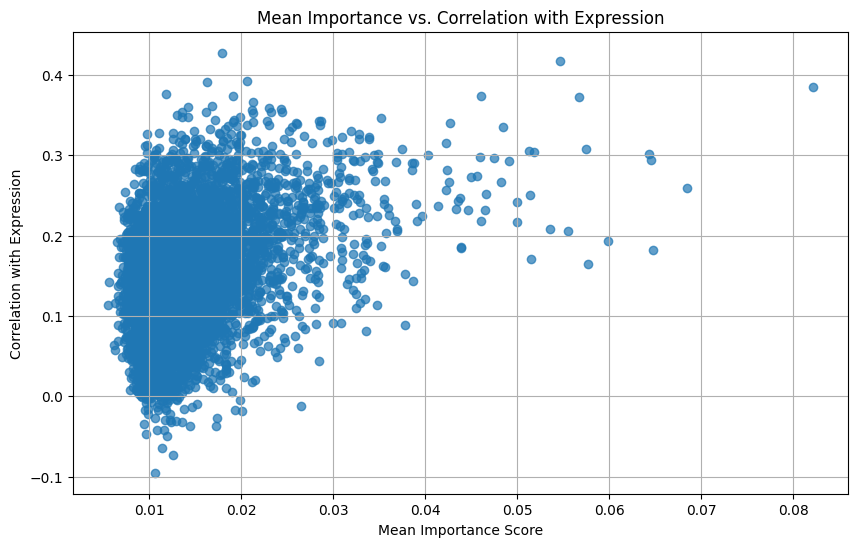

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the datasets
# Replace with your actual file paths
importance_scores = pd.read_csv("percent_importances.csv", index_col=0)
expression_values = pd.read_csv("/scratch/lcornelis/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124_age_adjusted.csv", index_col=0)

# List of columns to exclude (e.g., "mutation")
non_protein_columns = ["Mutation"]

# Filter out non-protein columns
importance_scores = importance_scores.drop(columns=non_protein_columns, errors="ignore")
expression_values = expression_values.drop(columns=non_protein_columns, errors="ignore")

# Step 2: Align datasets by Patient IDs
# Filter expression values to match the subset of patients in importance scores
expression_values = expression_values.loc[importance_scores.index]
nfl3_mean_values = expression_values["NFL3_MEAN"]

# Ensure columns (proteins) align between the two datasets
common_proteins = importance_scores.columns.intersection(expression_values.columns)
print(common_proteins)
importance_scores = importance_scores[common_proteins]
expression_values = expression_values[common_proteins]
print("Are patient IDs aligned?", importance_scores.index.equals(expression_values.index))

# Step 3: Compute correlations per protein
correlations = {}
for protein in common_proteins:
    # Compute Pearson correlation for the subset of patients
    correlations[protein] = np.corrcoef(
        importance_scores[protein], expression_values[protein]
    )[0, 1]

# Convert correlations to a DataFrame
correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])

# Step 4: Calculate mean importance score per protein
mean_importance = importance_scores.mean(axis=0)
correlations_df['Mean Importance'] = mean_importance

# Step 5: Plot mean importance vs. correlation
plt.figure(figsize=(10, 6))
plt.scatter(correlations_df['Mean Importance'], correlations_df['Correlation'], alpha=0.7)
plt.xlabel('Mean Importance Score')
plt.ylabel('Correlation with Expression')
plt.title('Mean Importance vs. Correlation with Expression')
plt.grid(True)
plt.savefig("mean_importance_vs_correlation.png")
plt.show()

# Optional: Save results to a CSV file
correlations_df.to_csv("protein_correlation_analysis.csv")

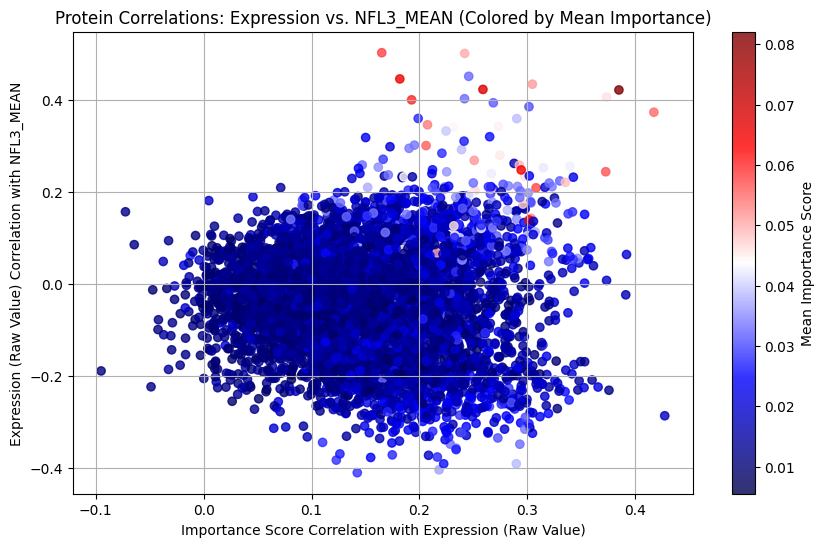

In [3]:
nfl3_correlations = {}
for protein in common_proteins:
    nfl3_correlations[protein] = np.corrcoef(
        expression_values[protein], nfl3_mean_values
    )[0, 1]

# Step 2: Add NFL3_MEAN correlations to correlations_df
correlations_df['Correlation with NFL3_MEAN'] = pd.Series(nfl3_correlations)

# Step 3: Combine and visualize correlations with color by mean importance score
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    correlations_df['Correlation'],  # Correlation with expression
    correlations_df['Correlation with NFL3_MEAN'],  # Correlation with NFL3_MEAN
    c=correlations_df['Mean Importance'],  # Color by mean importance
    cmap='seismic',  # Colormap for visualization
    alpha=0.8
)
plt.colorbar(sc, label='Mean Importance Score')  # Add colorbar for reference
plt.xlabel('Importance Score Correlation with Expression (Raw Value)')
plt.ylabel('Expression (Raw Value) Correlation with NFL3_MEAN')
plt.title('Protein Correlations: Expression vs. NFL3_MEAN (Colored by Mean Importance)')
plt.grid(True)
plt.savefig("correlation_with_expression_vs_NFL3_MEAN_colored.png")
plt.show()

In [ ]:

import matplotlib.pyplot as plt
from scipy.stats import linregress

# Step 1: Sort proteins by correlation
sorted_proteins = correlations_df.sort_values(by='Correlation', ascending=False).index

# Step 2: Define chunk size and split into groups
chunk_size = 100  # Number of proteins per plot
n_chunks = (len(sorted_proteins) + chunk_size - 1) // chunk_size  # Total number of chunks

# Step 3: Loop through chunks and display plots
for chunk_idx in range(n_chunks):
    # Get the proteins for the current chunk
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, len(sorted_proteins))
    chunk_proteins = sorted_proteins[start_idx:end_idx]

    # Create subplots for this chunk
    n_cols = 5  # Number of columns in the grid
    n_rows = (len(chunk_proteins) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    fig.suptitle(f"Expression (Raw) vs Importance (Chunk {chunk_idx + 1})", fontsize=16)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    # Plot each protein in this chunk
    for i, protein in enumerate(chunk_proteins):
        ax = axes[i]

        # Extract data for the current protein
        importance = importance_scores[protein]
        expression = expression_values[protein]

        # Compute the regression line
        slope, intercept, r_value, p_value, std_err = linregress(expression, importance)
        line = slope * expression + intercept

        # Scatter plot and regression line
        ax.scatter(expression, importance, alpha=0.7, s=10, label="Data Points")
        ax.plot(expression, line, color="red", linewidth=1, label=f"r={r_value:.2f}")

        # Add title and labels
        ax.set_title(f"{protein}\n(r={r_value:.2f})", fontsize=8)  # Add correlation value to title
        ax.set_xlabel("Expression (raw)", fontsize=8)
        ax.set_ylabel("Importance", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.grid(True)

    # Hide unused axes in this chunk
    for j in range(len(chunk_proteins), len(axes)):
        axes[j].axis('off')

    # Adjust layout and display the plot in the notebook
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()  # Display the figure in the notebook